# Imports

In [18]:
import os
import torch
import random
import math
import h5py
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.optim import lr_scheduler
from google.colab import drive, runtime
from tqdm import tqdm
from torch.utils.data import BatchSampler, TensorDataset, DataLoader, Dataset, Subset
from torchvision import models, transforms
from torchvision.transforms import v2
!pip install audiomentations
!pip install torchinfo
!pip install pytorch-metric-learning
from pytorch_metric_learning import losses, miners, regularizers, samplers, distances, reducers
from torchinfo import summary
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, TimeMask, TanhDistortion

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

Loading Data

In [2]:
with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/train_data.h5', 'r') as train_file:
    train_data = np.array(train_file['data'])
    train_labels = np.array(train_file['labels'])

with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/val_data.h5', 'r') as val_file:
    val_data = np.array(val_file['data'])
    val_labels = np.array(val_file['labels'])

with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/test_data.h5', 'r') as test_file:
    test_data = np.array(test_file['data'])
    test_labels = np.array(test_file['labels'])

Data Augmentation

In [30]:
class DataAugmentation(nn.Module):
    def __init__(self):
        super(DataAugmentation, self).__init__()
        self.transforms = Compose([
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
            TanhDistortion(min_distortion=0.01, max_distortion=0.7, p=0.5),
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
            PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
            TimeMask(min_band_part=0.1, max_band_part=0.15, p=0.5),
        ])

    def forward(self, song, sample_rate):
        augmented_song = self.transforms(song, sample_rate=sample_rate)
        return augmented_song

Create Dataset

In [31]:
class AudioDataset(Dataset):
    def __init__(self, input_data, input_labels, sample_rate=16000, n_mels=128, mean=6.5304, std=11.8924, transform=None):
        self.input_data = input_data
        self.input_labels = input_labels
        self.sr = sample_rate
        self.n_mels = n_mels
        self.mean = mean
        self.std = std
        self.transform = transform
        self.mel_spec_transform = T.MelSpectrogram(sample_rate=self.sr, n_mels=self.n_mels, n_fft=2048, hop_length=512)
        self.log_mel_spec_transform = T.AmplitudeToDB()
        self.image_transforms = transform = v2.Compose([
                                                        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                                        v2.Normalize((self.mean,), (self.std,))
                                                    ])

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        song = self.input_data[idx]
        genre = self.input_labels[idx]
        if self.transform:
            song = self.transform(song, self.sr)

        mel_spec = self.mel_spec_transform(torch.from_numpy(song))
        log_mel_spec = self.log_mel_spec_transform(mel_spec)
        mel_spec_tensor = log_mel_spec.unsqueeze(0)
        mel_spec_tensor = self.image_transforms(mel_spec_tensor)

        return mel_spec_tensor, genre


audio_train_dataset = AudioDataset(input_data=train_data, input_labels=train_labels, transform=DataAugmentation())
audio_val_dataset = AudioDataset(input_data=val_data, input_labels=val_labels, transform=None)
audio_test_dataset = AudioDataset(input_data=test_data, input_labels=test_labels, transform=None)

train_batch_sampler = samplers.MPerClassSampler(labels=audio_train_dataset.input_labels, m=48, batch_size=384)
val_batch_sampler = samplers.MPerClassSampler(labels=audio_val_dataset.input_labels, m=48, batch_size=384)
test_batch_sampler = samplers.MPerClassSampler(labels=audio_test_dataset.input_labels, m=48, batch_size=384)

audio_train_loader = DataLoader(audio_train_dataset, batch_size=432, sampler=train_batch_sampler, pin_memory=True)
audio_val_loader = DataLoader(audio_val_dataset, batch_size=432, sampler=val_batch_sampler, pin_memory=True)
audio_test_loader = DataLoader(audio_test_dataset, batch_size=432, sampler=test_batch_sampler, pin_memory=True)

In [5]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

def get_mean_std(data):
  mean = np.mean(data, axis=(0, 1, 2))
  std = np.std(data, axis=(0, 1, 2))
  return mean, std

# Model

Print Layer (debugging)

In [6]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print("X shape:", x.shape)
        return x


Positional Encoding

In [7]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

Separable Convolution 2D Layer

In [8]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

Residual Block

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, num_layers: int, pool: bool, short: bool):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pooling = pool
        self.short = short

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 1):
            layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        else:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)

        if self.pooling:
            out = self.pool(out)

        if self.short:
            shortcut = self.shortcut(x)
            out = out + shortcut
            out = self.sact(out)

        return out

Embedding Model

In [29]:
class EmbeddingModel(nn.Module):
    def __init__(self):
      super(EmbeddingModel, self).__init__()
      self.input_layer = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, bias=False),
          nn.SELU(),
      )

      self.conv_layers = nn.Sequential(
          ResidualBlock(in_channels=64, out_channels=64, kernel_size=3, num_layers=2, pool=True, short=True),
          ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, num_layers=2, pool=True, short=True),
          ResidualBlock(in_channels=128, out_channels=256, kernel_size=3, num_layers=2, pool=True, short=True),
          nn.Dropout2d(p=0.5),
      )

      self.dense_layers = nn.Sequential(
          nn.Linear(in_features=256, out_features=512, bias=False),
          nn.SELU(),
          nn.Linear(in_features=512, out_features=256, bias=False),
          nn.SELU(),
          nn.Dropout(p=0.7),
      )

      self.output = nn.Linear(in_features=256, out_features=128)

    def forward(self, x):
      x = self.input_layer(x)
      x = self.conv_layers(x)
      x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
      x = self.dense_layers(x)
      out = self.output(x)
      return out

    def get_embedding(self, x):
      return self.forward(x)

# Utils

Early Stopping

In [11]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def reset_loss(self):
        self.min_validation_loss = float('inf')

Autoclip

In [12]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [13]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses):
  checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
      }
  torch.save(checkpoint, f'/content/drive/My Drive/Projects/NeuraBeat/Checkpoints/model_checkpoint_{epoch}.pt')

def load_checkpoint(filepath, model, optimizer, scheduler):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    return model, optimizer, scheduler, start_epoch, train_losses, val_losses

# Training Loop

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = torch.cuda.is_available()
embedding_model = EmbeddingModel().to(device)
start_epoch = 0
num_epochs = 30
learning_rate = 1e-3
margin = 1.
batch_size = 384

loss_fn = losses.TripletMarginLoss(margin=margin, distance = distances.CosineSimilarity(),
                                     reducer = reducers.ThresholdReducer(high=0.0),
                                     embedding_regularizer = regularizers.LpRegularizer())
miner = miners.BatchEasyHardMiner(pos_strategy='semihard', neg_strategy='hard')

optimizer = optim.AdamW(embedding_model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=15, T_mult=1)
autoclipper = AutoClip(percentile=10)

train_losses = []
val_losses = []

print(summary(embedding_model, input_size=(batch_size, 1, 128, 94)))

checkpoint_path = '/content/drive/My Drive/Projects/NeuraBeat/Checkpoints/model_checkpoint_95.pt'
if os.path.isfile(checkpoint_path):
    embedding_model, optimizer, scheduler, start_epoch, train_losses, val_losses = load_checkpoint(checkpoint_path, embedding_model, optimizer, scheduler)
    print(f"Loaded checkpoint from epoch {start_epoch}")

def train_loop(train_loader, model, miner, criterion, optimizer, device, epoch):
    size = len(train_loader.dataset)
    model.train()
    avg_train_loss = 0.0
    num_batches = len(train_loader)

    # Training loop
    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        triplets = miner(outputs, targets)

        loss = criterion(outputs, targets, triplets)
        avg_train_loss += loss.item()
        loss.backward()

        autoclipper(model)
        optimizer.step()

        if (batch + 1) % 10 == 0:
            loss = avg_train_loss / (batch + 1)
            print(f"Training loss: {loss:>7f}")

    avg_train_loss = avg_train_loss / num_batches
    return avg_train_loss

def val_loop(val_loader, model, miner, criterion, device, epoch):
    model.eval()
    avg_val_loss = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            triplets = miner(outputs, targets)

            loss = criterion(outputs, targets, triplets)
            avg_val_loss += loss.item()


    avg_val_loss = avg_val_loss / num_batches
    return avg_val_loss

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    avg_train_loss = train_loop(audio_train_loader, embedding_model, miner, loss_fn, optimizer, device, epoch+1)
    avg_val_loss = val_loop(audio_val_loader, embedding_model, miner, loss_fn, device, epoch+1)
    print(f"Train loss: {avg_train_loss:>8f} - Val loss: {avg_val_loss:>8f} \n")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print("Last learning rate:", scheduler.get_last_lr())
    scheduler.step()

    save_checkpoint(embedding_model, optimizer, scheduler, epoch+1, train_losses, val_losses)

    if (epoch + 1 == 15):
        miner = miners.BatchEasyHardMiner(pos_strategy='hard', neg_strategy='hard')


Layer (type:depth-idx)                        Output Shape              Param #
EmbeddingModel                                [384, 128]                --
├─Sequential: 1-1                             [384, 64, 124, 90]        --
│    └─Conv2d: 2-1                            [384, 64, 124, 90]        1,600
│    └─SELU: 2-2                              [384, 64, 124, 90]        --
├─Sequential: 1-2                             [384, 256, 16, 12]        --
│    └─ResidualBlock: 2-3                     [384, 64, 62, 45]         --
│    │    └─Sequential: 3-1                   [384, 64, 124, 90]        4,672
│    │    └─Sequential: 3-2                   [384, 64, 124, 90]        4,672
│    │    └─MaxPool2d: 3-3                    [384, 64, 62, 45]         --
│    │    └─Conv2d: 3-4                       [384, 64, 62, 45]         4,096
│    │    └─SELU: 3-5                         [384, 64, 62, 45]         --
│    └─ResidualBlock: 2-4                     [384, 128, 31, 23]        --
│    │  

  4%|▍         | 10/232 [01:29<33:23,  9.02s/it]

Training loss: 0.699847


  9%|▊         | 20/232 [03:00<32:24,  9.17s/it]

Training loss: 0.471069


 13%|█▎        | 30/232 [04:30<30:27,  9.04s/it]

Training loss: 0.360777


 17%|█▋        | 40/232 [06:01<28:36,  8.94s/it]

Training loss: 0.293041


 22%|██▏       | 50/232 [07:32<27:22,  9.02s/it]

Training loss: 0.246612


 26%|██▌       | 60/232 [09:03<25:53,  9.03s/it]

Training loss: 0.212637


 30%|███       | 70/232 [10:35<24:42,  9.15s/it]

Training loss: 0.186760


 34%|███▍      | 80/232 [12:06<22:51,  9.03s/it]

Training loss: 0.166563


 39%|███▉      | 90/232 [13:36<21:35,  9.12s/it]

Training loss: 0.150344


 43%|████▎     | 100/232 [15:07<20:08,  9.16s/it]

Training loss: 0.137015


 47%|████▋     | 110/232 [16:38<18:27,  9.08s/it]

Training loss: 0.125881


 52%|█████▏    | 120/232 [18:11<17:08,  9.19s/it]

Training loss: 0.116436


 56%|█████▌    | 130/232 [19:41<15:24,  9.07s/it]

Training loss: 0.108327


 60%|██████    | 140/232 [21:11<13:48,  9.01s/it]

Training loss: 0.101291


 65%|██████▍   | 150/232 [22:41<12:24,  9.08s/it]

Training loss: 0.095111


 69%|██████▉   | 160/232 [24:11<10:50,  9.03s/it]

Training loss: 0.089651


 73%|███████▎  | 170/232 [25:42<09:31,  9.22s/it]

Training loss: 0.084793


 78%|███████▊  | 180/232 [27:17<08:17,  9.57s/it]

Training loss: 0.080438


 82%|████████▏ | 190/232 [28:50<06:31,  9.31s/it]

Training loss: 0.076514


 86%|████████▌ | 200/232 [30:23<04:53,  9.18s/it]

Training loss: 0.072958


 91%|█████████ | 210/232 [31:55<03:26,  9.39s/it]

Training loss: 0.069721


 95%|█████████▍| 220/232 [33:28<01:49,  9.17s/it]

Training loss: 0.066770


 99%|█████████▉| 230/232 [35:00<00:17,  8.96s/it]

Training loss: 0.064064


100%|██████████| 232/232 [35:10<00:00,  9.10s/it]


Train loss: 0.063549 - Val loss: 0.001776 

Last learning rate: [0.001]
Epoch 2
-------------------------------


  4%|▍         | 10/232 [01:36<35:21,  9.56s/it]

Training loss: 0.004310


  9%|▊         | 20/232 [03:06<31:34,  8.93s/it]

Training loss: 0.004234


 13%|█▎        | 30/232 [04:37<30:39,  9.10s/it]

Training loss: 0.004134


 17%|█▋        | 40/232 [06:07<28:35,  8.93s/it]

Training loss: 0.004042


 22%|██▏       | 50/232 [07:39<28:09,  9.28s/it]

Training loss: 0.003965


 26%|██▌       | 60/232 [09:11<26:28,  9.23s/it]

Training loss: 0.003893


 30%|███       | 70/232 [10:42<24:36,  9.11s/it]

Training loss: 0.003824


 34%|███▍      | 80/232 [12:11<22:46,  8.99s/it]

Training loss: 0.003757


 39%|███▉      | 90/232 [13:43<22:04,  9.33s/it]

Training loss: 0.003697


 43%|████▎     | 100/232 [15:14<20:01,  9.10s/it]

Training loss: 0.003639


 47%|████▋     | 110/232 [16:45<18:45,  9.23s/it]

Training loss: 0.003580


 52%|█████▏    | 120/232 [18:16<16:49,  9.01s/it]

Training loss: 0.003526


 56%|█████▌    | 130/232 [19:46<15:06,  8.89s/it]

Training loss: 0.003475


 60%|██████    | 140/232 [21:17<13:59,  9.13s/it]

Training loss: 0.003426


 65%|██████▍   | 150/232 [22:47<12:24,  9.08s/it]

Training loss: 0.003379


 69%|██████▉   | 160/232 [24:17<10:55,  9.11s/it]

Training loss: 0.003332


 73%|███████▎  | 170/232 [25:46<09:14,  8.95s/it]

Training loss: 0.003289


 78%|███████▊  | 180/232 [27:17<07:48,  9.01s/it]

Training loss: 0.003247


 82%|████████▏ | 190/232 [28:46<06:16,  8.96s/it]

Training loss: 0.003206


 86%|████████▌ | 200/232 [30:17<04:50,  9.08s/it]

Training loss: 0.003166


 91%|█████████ | 210/232 [31:46<03:15,  8.88s/it]

Training loss: 0.003129


 95%|█████████▍| 220/232 [33:16<01:48,  9.03s/it]

Training loss: 0.003092


 99%|█████████▉| 230/232 [34:46<00:17,  9.00s/it]

Training loss: 0.003056


100%|██████████| 232/232 [34:56<00:00,  9.04s/it]


Train loss: 0.003050 - Val loss: 0.001328 

Last learning rate: [0.0009890738003669028]
Epoch 3
-------------------------------


  4%|▍         | 10/232 [01:30<33:24,  9.03s/it]

Training loss: 0.002232


  9%|▊         | 20/232 [02:59<31:35,  8.94s/it]

Training loss: 0.002204


 13%|█▎        | 30/232 [04:29<30:10,  8.96s/it]

Training loss: 0.002174


 17%|█▋        | 40/232 [05:59<28:21,  8.86s/it]

Training loss: 0.002152


 22%|██▏       | 50/232 [07:28<27:19,  9.01s/it]

Training loss: 0.002132


 26%|██▌       | 60/232 [08:57<25:49,  9.01s/it]

Training loss: 0.002112


 30%|███       | 70/232 [10:26<24:06,  8.93s/it]

Training loss: 0.002099


 34%|███▍      | 80/232 [11:57<22:48,  9.00s/it]

Training loss: 0.002081


 39%|███▉      | 90/232 [13:26<21:09,  8.94s/it]

Training loss: 0.002064


 43%|████▎     | 100/232 [14:56<19:53,  9.04s/it]

Training loss: 0.002046


 47%|████▋     | 110/232 [16:25<17:57,  8.83s/it]

Training loss: 0.002028


 52%|█████▏    | 120/232 [17:55<16:45,  8.97s/it]

Training loss: 0.002011


 56%|█████▌    | 130/232 [19:31<16:00,  9.42s/it]

Training loss: 0.001990


 60%|██████    | 140/232 [21:02<13:56,  9.10s/it]

Training loss: 0.001970


 65%|██████▍   | 150/232 [22:34<12:35,  9.21s/it]

Training loss: 0.001953


 69%|██████▉   | 160/232 [24:04<10:57,  9.13s/it]

Training loss: 0.001945


 73%|███████▎  | 170/232 [25:35<09:20,  9.04s/it]

Training loss: 0.001933


 78%|███████▊  | 180/232 [27:05<07:47,  8.99s/it]

Training loss: 0.001920


 82%|████████▏ | 190/232 [28:36<06:19,  9.02s/it]

Training loss: 0.001907


 86%|████████▌ | 200/232 [30:07<04:50,  9.09s/it]

Training loss: 0.001894


 91%|█████████ | 210/232 [31:39<03:26,  9.37s/it]

Training loss: 0.001882


 95%|█████████▍| 220/232 [33:08<01:46,  8.90s/it]

Training loss: 0.001870


 99%|█████████▉| 230/232 [34:39<00:18,  9.11s/it]

Training loss: 0.001858


100%|██████████| 232/232 [34:50<00:00,  9.01s/it]


Train loss: 0.001856 - Val loss: 0.000873 

Last learning rate: [0.0009567727288213005]
Epoch 4
-------------------------------


  4%|▍         | 10/232 [01:32<33:56,  9.17s/it]

Training loss: 0.001572


  9%|▊         | 20/232 [03:01<31:29,  8.91s/it]

Training loss: 0.001552


 13%|█▎        | 30/232 [04:32<30:12,  8.97s/it]

Training loss: 0.001543


 17%|█▋        | 40/232 [06:03<29:29,  9.22s/it]

Training loss: 0.001532


 22%|██▏       | 50/232 [07:33<27:15,  8.99s/it]

Training loss: 0.001522


 26%|██▌       | 60/232 [09:03<25:43,  8.97s/it]

Training loss: 0.001510


 30%|███       | 70/232 [10:35<24:46,  9.18s/it]

Training loss: 0.001500


 34%|███▍      | 80/232 [12:03<22:26,  8.86s/it]

Training loss: 0.001490


 39%|███▉      | 90/232 [13:33<20:49,  8.80s/it]

Training loss: 0.001481


 43%|████▎     | 100/232 [15:04<20:04,  9.13s/it]

Training loss: 0.001473


 47%|████▋     | 110/232 [16:36<18:38,  9.17s/it]

Training loss: 0.001462


 52%|█████▏    | 120/232 [18:08<16:59,  9.10s/it]

Training loss: 0.001445


 56%|█████▌    | 130/232 [19:41<15:52,  9.34s/it]

Training loss: 0.001428


 60%|██████    | 140/232 [21:11<13:46,  8.99s/it]

Training loss: 0.001413


 65%|██████▍   | 150/232 [22:43<12:29,  9.14s/it]

Training loss: 0.001398


 69%|██████▉   | 160/232 [24:13<10:35,  8.83s/it]

Training loss: 0.001382


 73%|███████▎  | 170/232 [25:43<09:13,  8.93s/it]

Training loss: 0.001368


 78%|███████▊  | 180/232 [27:13<07:47,  8.99s/it]

Training loss: 0.001353


 82%|████████▏ | 190/232 [28:42<06:15,  8.95s/it]

Training loss: 0.001340


 86%|████████▌ | 200/232 [30:13<04:54,  9.22s/it]

Training loss: 0.001327


 91%|█████████ | 210/232 [31:43<03:19,  9.06s/it]

Training loss: 0.001315


 95%|█████████▍| 220/232 [33:17<01:56,  9.67s/it]

Training loss: 0.001303


 99%|█████████▉| 230/232 [34:53<00:19,  9.63s/it]

Training loss: 0.001292


100%|██████████| 232/232 [35:03<00:00,  9.07s/it]


Train loss: 0.001290 - Val loss: 0.000508 

Last learning rate: [0.0009045084971874737]
Epoch 5
-------------------------------


  4%|▍         | 10/232 [01:30<33:38,  9.09s/it]

Training loss: 0.001013


  9%|▊         | 20/232 [02:59<30:59,  8.77s/it]

Training loss: 0.001014


 13%|█▎        | 30/232 [04:29<30:24,  9.03s/it]

Training loss: 0.001017


 17%|█▋        | 40/232 [06:00<28:33,  8.93s/it]

Training loss: 0.001014


 22%|██▏       | 50/232 [07:30<27:16,  8.99s/it]

Training loss: 0.001004


 26%|██▌       | 60/232 [09:00<25:30,  8.90s/it]

Training loss: 0.000997


 30%|███       | 70/232 [10:30<23:59,  8.89s/it]

Training loss: 0.000992


 34%|███▍      | 80/232 [12:01<23:16,  9.19s/it]

Training loss: 0.000997


 39%|███▉      | 90/232 [13:34<22:05,  9.33s/it]

Training loss: 0.000993


 43%|████▎     | 100/232 [15:07<20:16,  9.21s/it]

Training loss: 0.000988


 47%|████▋     | 110/232 [16:38<18:17,  9.00s/it]

Training loss: 0.000987


 52%|█████▏    | 120/232 [18:07<16:29,  8.83s/it]

Training loss: 0.000981


 56%|█████▌    | 130/232 [19:37<15:18,  9.00s/it]

Training loss: 0.000977


 60%|██████    | 140/232 [21:07<13:47,  9.00s/it]

Training loss: 0.000971


 65%|██████▍   | 150/232 [22:38<12:22,  9.06s/it]

Training loss: 0.000969


 69%|██████▉   | 160/232 [24:07<10:48,  9.01s/it]

Training loss: 0.000973


 73%|███████▎  | 170/232 [25:38<09:25,  9.12s/it]

Training loss: 0.000978


 78%|███████▊  | 180/232 [27:09<07:55,  9.14s/it]

Training loss: 0.000980


 82%|████████▏ | 190/232 [28:38<06:22,  9.10s/it]

Training loss: 0.000978


 86%|████████▌ | 200/232 [30:12<04:55,  9.25s/it]

Training loss: 0.000972


 91%|█████████ | 210/232 [31:43<03:19,  9.07s/it]

Training loss: 0.000967


 95%|█████████▍| 220/232 [33:14<01:50,  9.22s/it]

Training loss: 0.000961


 99%|█████████▉| 230/232 [34:45<00:18,  9.22s/it]

Training loss: 0.000957


100%|██████████| 232/232 [34:56<00:00,  9.04s/it]


Train loss: 0.000957 - Val loss: 0.000673 

Last learning rate: [0.0008345653031794292]
Epoch 6
-------------------------------


  4%|▍         | 10/232 [01:31<33:30,  9.05s/it]

Training loss: 0.000951


  9%|▊         | 20/232 [03:02<32:43,  9.26s/it]

Training loss: 0.000901


 13%|█▎        | 30/232 [04:34<30:45,  9.14s/it]

Training loss: 0.000871


 17%|█▋        | 40/232 [06:04<28:34,  8.93s/it]

Training loss: 0.000860


 22%|██▏       | 50/232 [07:38<28:49,  9.50s/it]

Training loss: 0.000851


 26%|██▌       | 60/232 [09:12<26:27,  9.23s/it]

Training loss: 0.000843


 30%|███       | 70/232 [10:44<24:42,  9.15s/it]

Training loss: 0.000834


 34%|███▍      | 80/232 [12:16<23:26,  9.25s/it]

Training loss: 0.000831


 39%|███▉      | 90/232 [13:48<21:47,  9.21s/it]

Training loss: 0.000839


 43%|████▎     | 100/232 [15:20<19:57,  9.07s/it]

Training loss: 0.000846


 47%|████▋     | 110/232 [16:50<18:13,  8.96s/it]

Training loss: 0.000844


 52%|█████▏    | 120/232 [18:22<17:02,  9.13s/it]

Training loss: 0.000838


 56%|█████▌    | 130/232 [19:53<15:30,  9.13s/it]

Training loss: 0.000837


 60%|██████    | 140/232 [21:24<13:48,  9.00s/it]

Training loss: 0.000833


 65%|██████▍   | 150/232 [22:56<12:33,  9.19s/it]

Training loss: 0.000827


 69%|██████▉   | 160/232 [24:28<10:54,  9.09s/it]

Training loss: 0.000822


 73%|███████▎  | 170/232 [25:58<09:20,  9.05s/it]

Training loss: 0.000817


 78%|███████▊  | 180/232 [27:29<07:57,  9.18s/it]

Training loss: 0.000812


 82%|████████▏ | 190/232 [28:59<06:12,  8.86s/it]

Training loss: 0.000814


 86%|████████▌ | 200/232 [30:29<04:46,  8.96s/it]

Training loss: 0.000811


 91%|█████████ | 210/232 [31:59<03:20,  9.12s/it]

Training loss: 0.000811


 95%|█████████▍| 220/232 [33:29<01:48,  9.03s/it]

Training loss: 0.000812


 99%|█████████▉| 230/232 [35:00<00:18,  9.02s/it]

Training loss: 0.000812


100%|██████████| 232/232 [35:10<00:00,  9.10s/it]


Train loss: 0.000812 - Val loss: 0.000699 

Last learning rate: [0.00075]
Epoch 7
-------------------------------


  4%|▍         | 10/232 [01:31<33:34,  9.08s/it]

Training loss: 0.000736


  9%|▊         | 20/232 [03:00<31:30,  8.92s/it]

Training loss: 0.000749


 13%|█▎        | 30/232 [04:30<30:38,  9.10s/it]

Training loss: 0.000735


 17%|█▋        | 40/232 [05:58<28:28,  8.90s/it]

Training loss: 0.000738


 22%|██▏       | 50/232 [07:29<27:37,  9.11s/it]

Training loss: 0.000730


 26%|██▌       | 60/232 [09:00<26:30,  9.24s/it]

Training loss: 0.000725


 30%|███       | 70/232 [10:31<24:13,  8.98s/it]

Training loss: 0.000723


 34%|███▍      | 80/232 [12:01<22:40,  8.95s/it]

Training loss: 0.000716


 39%|███▉      | 90/232 [13:31<21:21,  9.03s/it]

Training loss: 0.000715


 43%|████▎     | 100/232 [15:02<20:17,  9.22s/it]

Training loss: 0.000709


 47%|████▋     | 110/232 [16:32<18:13,  8.96s/it]

Training loss: 0.000704


 52%|█████▏    | 120/232 [18:02<17:04,  9.14s/it]

Training loss: 0.000701


 56%|█████▌    | 130/232 [19:32<15:16,  8.99s/it]

Training loss: 0.000704


 60%|██████    | 140/232 [21:01<13:39,  8.91s/it]

Training loss: 0.000705


 65%|██████▍   | 150/232 [22:31<12:12,  8.93s/it]

Training loss: 0.000704


 69%|██████▉   | 160/232 [24:01<10:49,  9.02s/it]

Training loss: 0.000703


 73%|███████▎  | 170/232 [25:32<09:20,  9.04s/it]

Training loss: 0.000699


 78%|███████▊  | 180/232 [27:01<07:49,  9.02s/it]

Training loss: 0.000696


 82%|████████▏ | 190/232 [28:32<06:19,  9.03s/it]

Training loss: 0.000693


 86%|████████▌ | 200/232 [30:01<04:42,  8.83s/it]

Training loss: 0.000695


 91%|█████████ | 210/232 [31:31<03:15,  8.90s/it]

Training loss: 0.000695


 95%|█████████▍| 220/232 [33:01<01:46,  8.92s/it]

Training loss: 0.000693


 99%|█████████▉| 230/232 [34:31<00:18,  9.12s/it]

Training loss: 0.000695


100%|██████████| 232/232 [34:41<00:00,  8.97s/it]


Train loss: 0.000695 - Val loss: 0.000561 

Last learning rate: [0.0006545084971874737]
Epoch 8
-------------------------------


  4%|▍         | 10/232 [01:24<31:05,  8.40s/it]

Training loss: 0.000585


  9%|▊         | 20/232 [02:54<32:38,  9.24s/it]

Training loss: 0.000601


 13%|█▎        | 30/232 [04:24<30:19,  9.01s/it]

Training loss: 0.000617


 17%|█▋        | 40/232 [05:53<28:18,  8.85s/it]

Training loss: 0.000623


 22%|██▏       | 50/232 [07:23<26:59,  8.90s/it]

Training loss: 0.000611


 26%|██▌       | 60/232 [08:52<25:39,  8.95s/it]

Training loss: 0.000613


 30%|███       | 70/232 [10:21<23:56,  8.87s/it]

Training loss: 0.000609


 34%|███▍      | 80/232 [11:47<21:48,  8.61s/it]

Training loss: 0.000601


 39%|███▉      | 90/232 [13:17<21:45,  9.19s/it]

Training loss: 0.000602


 43%|████▎     | 100/232 [14:44<18:32,  8.42s/it]

Training loss: 0.000600


 47%|████▋     | 110/232 [16:08<17:07,  8.42s/it]

Training loss: 0.000598


 52%|█████▏    | 120/232 [17:35<16:05,  8.62s/it]

Training loss: 0.000596


 56%|█████▌    | 130/232 [19:03<15:04,  8.87s/it]

Training loss: 0.000593


 60%|██████    | 140/232 [20:29<12:50,  8.37s/it]

Training loss: 0.000590


 65%|██████▍   | 150/232 [21:55<11:43,  8.58s/it]

Training loss: 0.000592


 69%|██████▉   | 160/232 [23:20<10:15,  8.55s/it]

Training loss: 0.000590


 73%|███████▎  | 170/232 [24:44<08:46,  8.49s/it]

Training loss: 0.000588


 78%|███████▊  | 180/232 [26:09<07:20,  8.47s/it]

Training loss: 0.000585


 82%|████████▏ | 190/232 [27:34<05:58,  8.54s/it]

Training loss: 0.000585


 86%|████████▌ | 200/232 [28:59<04:33,  8.54s/it]

Training loss: 0.000583


 91%|█████████ | 210/232 [30:23<03:06,  8.50s/it]

Training loss: 0.000581


 95%|█████████▍| 220/232 [31:49<01:43,  8.59s/it]

Training loss: 0.000579


 99%|█████████▉| 230/232 [33:14<00:17,  8.50s/it]

Training loss: 0.000577


100%|██████████| 232/232 [33:23<00:00,  8.64s/it]


Train loss: 0.000577 - Val loss: 0.000442 

Last learning rate: [0.0005522642316338268]
Epoch 9
-------------------------------


  4%|▍         | 10/232 [01:25<31:19,  8.47s/it]

Training loss: 0.000494


  9%|▊         | 20/232 [02:50<29:56,  8.47s/it]

Training loss: 0.000513


 13%|█▎        | 30/232 [04:16<28:39,  8.51s/it]

Training loss: 0.000509


 17%|█▋        | 40/232 [05:42<27:22,  8.55s/it]

Training loss: 0.000508


 22%|██▏       | 50/232 [07:05<25:17,  8.34s/it]

Training loss: 0.000509


 26%|██▌       | 60/232 [08:29<23:59,  8.37s/it]

Training loss: 0.000507


 30%|███       | 70/232 [09:54<22:39,  8.39s/it]

Training loss: 0.000504


 34%|███▍      | 80/232 [11:19<21:29,  8.49s/it]

Training loss: 0.000499


 39%|███▉      | 90/232 [12:43<19:53,  8.41s/it]

Training loss: 0.000499


 43%|████▎     | 100/232 [14:08<18:36,  8.46s/it]

Training loss: 0.000500


 47%|████▋     | 110/232 [15:33<17:25,  8.57s/it]

Training loss: 0.000505


 52%|█████▏    | 120/232 [16:58<15:51,  8.49s/it]

Training loss: 0.000503


 56%|█████▌    | 130/232 [18:22<14:25,  8.48s/it]

Training loss: 0.000502


 60%|██████    | 140/232 [19:48<13:14,  8.63s/it]

Training loss: 0.000503


 65%|██████▍   | 150/232 [21:13<11:58,  8.76s/it]

Training loss: 0.000503


 69%|██████▉   | 160/232 [22:40<10:19,  8.60s/it]

Training loss: 0.000500


 73%|███████▎  | 170/232 [24:06<08:55,  8.64s/it]

Training loss: 0.000500


 78%|███████▊  | 180/232 [25:32<07:27,  8.60s/it]

Training loss: 0.000501


 82%|████████▏ | 190/232 [26:58<05:53,  8.41s/it]

Training loss: 0.000501


 86%|████████▌ | 200/232 [28:23<04:35,  8.62s/it]

Training loss: 0.000500


 91%|█████████ | 210/232 [29:49<03:08,  8.56s/it]

Training loss: 0.000498


 95%|█████████▍| 220/232 [31:13<01:40,  8.40s/it]

Training loss: 0.000496


 99%|█████████▉| 230/232 [32:43<00:17,  8.93s/it]

Training loss: 0.000495


100%|██████████| 232/232 [32:53<00:00,  8.51s/it]


Train loss: 0.000494 - Val loss: 0.000280 

Last learning rate: [0.00044773576836617336]
Epoch 10
-------------------------------


  4%|▍         | 10/232 [01:25<31:52,  8.62s/it]

Training loss: 0.000387


  9%|▊         | 20/232 [02:52<30:45,  8.70s/it]

Training loss: 0.000435


 13%|█▎        | 30/232 [04:18<28:56,  8.59s/it]

Training loss: 0.000446


 17%|█▋        | 40/232 [05:44<27:15,  8.52s/it]

Training loss: 0.000461


 22%|██▏       | 50/232 [07:11<25:55,  8.55s/it]

Training loss: 0.000468


 26%|██▌       | 60/232 [08:36<24:53,  8.68s/it]

Training loss: 0.000473


 30%|███       | 70/232 [10:01<22:50,  8.46s/it]

Training loss: 0.000474


 34%|███▍      | 80/232 [11:27<21:52,  8.64s/it]

Training loss: 0.000474


 39%|███▉      | 90/232 [12:51<19:35,  8.28s/it]

Training loss: 0.000475


 43%|████▎     | 100/232 [14:17<18:57,  8.62s/it]

Training loss: 0.000474


 47%|████▋     | 110/232 [15:43<17:13,  8.47s/it]

Training loss: 0.000473


 52%|█████▏    | 120/232 [17:09<15:56,  8.54s/it]

Training loss: 0.000473


 56%|█████▌    | 130/232 [18:35<14:40,  8.63s/it]

Training loss: 0.000471


 60%|██████    | 140/232 [20:02<13:05,  8.54s/it]

Training loss: 0.000469


 65%|██████▍   | 150/232 [21:28<11:51,  8.68s/it]

Training loss: 0.000467


 69%|██████▉   | 160/232 [22:56<10:21,  8.63s/it]

Training loss: 0.000466


 73%|███████▎  | 170/232 [24:23<09:04,  8.78s/it]

Training loss: 0.000463


 78%|███████▊  | 180/232 [25:49<07:21,  8.50s/it]

Training loss: 0.000460


 82%|████████▏ | 190/232 [27:16<06:03,  8.66s/it]

Training loss: 0.000455


 86%|████████▌ | 200/232 [28:41<04:34,  8.58s/it]

Training loss: 0.000451


 91%|█████████ | 210/232 [30:06<03:06,  8.50s/it]

Training loss: 0.000448


 95%|█████████▍| 220/232 [31:31<01:41,  8.45s/it]

Training loss: 0.000446


 99%|█████████▉| 230/232 [32:58<00:17,  8.72s/it]

Training loss: 0.000443


100%|██████████| 232/232 [33:07<00:00,  8.57s/it]


Train loss: 0.000442 - Val loss: 0.000236 

Last learning rate: [0.00034549150281252633]
Epoch 11
-------------------------------


  4%|▍         | 10/232 [01:25<31:47,  8.59s/it]

Training loss: 0.000307


  9%|▊         | 20/232 [02:51<30:12,  8.55s/it]

Training loss: 0.000307


 13%|█▎        | 30/232 [04:16<28:48,  8.56s/it]

Training loss: 0.000302


 17%|█▋        | 40/232 [05:42<26:55,  8.41s/it]

Training loss: 0.000299


 22%|██▏       | 50/232 [07:07<25:36,  8.44s/it]

Training loss: 0.000299


 26%|██▌       | 60/232 [08:33<24:37,  8.59s/it]

Training loss: 0.000297


 30%|███       | 70/232 [10:03<24:47,  9.18s/it]

Training loss: 0.000297


 34%|███▍      | 80/232 [11:34<22:31,  8.89s/it]

Training loss: 0.000301


 39%|███▉      | 90/232 [12:59<20:12,  8.54s/it]

Training loss: 0.000301


 43%|████▎     | 100/232 [14:29<20:04,  9.13s/it]

Training loss: 0.000300


 47%|████▋     | 110/232 [15:55<17:20,  8.53s/it]

Training loss: 0.000302


 52%|█████▏    | 120/232 [17:21<15:59,  8.57s/it]

Training loss: 0.000303


 56%|█████▌    | 130/232 [18:47<14:27,  8.50s/it]

Training loss: 0.000302


 60%|██████    | 140/232 [20:12<13:10,  8.59s/it]

Training loss: 0.000302


 65%|██████▍   | 150/232 [21:37<11:34,  8.47s/it]

Training loss: 0.000301


 69%|██████▉   | 160/232 [23:02<10:09,  8.46s/it]

Training loss: 0.000300


 73%|███████▎  | 170/232 [24:28<08:59,  8.70s/it]

Training loss: 0.000300


 78%|███████▊  | 180/232 [25:54<07:40,  8.85s/it]

Training loss: 0.000299


 82%|████████▏ | 190/232 [27:24<06:11,  8.85s/it]

Training loss: 0.000299


 86%|████████▌ | 200/232 [28:49<04:33,  8.54s/it]

Training loss: 0.000299


 91%|█████████ | 210/232 [30:14<03:06,  8.46s/it]

Training loss: 0.000298


 95%|█████████▍| 220/232 [31:40<01:43,  8.62s/it]

Training loss: 0.000297


 99%|█████████▉| 230/232 [33:05<00:16,  8.45s/it]

Training loss: 0.000297


100%|██████████| 232/232 [33:14<00:00,  8.60s/it]


Train loss: 0.000297 - Val loss: 0.000221 

Last learning rate: [0.0002500000000000001]
Epoch 12
-------------------------------


  4%|▍         | 10/232 [01:27<32:35,  8.81s/it]

Training loss: 0.000244


  9%|▊         | 20/232 [02:53<30:51,  8.73s/it]

Training loss: 0.000239


 13%|█▎        | 30/232 [04:18<28:51,  8.57s/it]

Training loss: 0.000236


 17%|█▋        | 40/232 [05:46<28:58,  9.05s/it]

Training loss: 0.000234


 22%|██▏       | 50/232 [07:12<25:51,  8.52s/it]

Training loss: 0.000234


 26%|██▌       | 60/232 [08:39<24:27,  8.53s/it]

Training loss: 0.000234


 30%|███       | 70/232 [10:04<22:48,  8.45s/it]

Training loss: 0.000235


 34%|███▍      | 80/232 [11:31<22:42,  8.97s/it]

Training loss: 0.000236


 39%|███▉      | 90/232 [12:59<20:22,  8.61s/it]

Training loss: 0.000235


 43%|████▎     | 100/232 [14:24<18:38,  8.47s/it]

Training loss: 0.000235


 47%|████▋     | 110/232 [15:49<17:19,  8.52s/it]

Training loss: 0.000237


 52%|█████▏    | 120/232 [17:13<15:53,  8.52s/it]

Training loss: 0.000236


 56%|█████▌    | 130/232 [18:38<14:26,  8.50s/it]

Training loss: 0.000237


 60%|██████    | 140/232 [20:02<12:47,  8.34s/it]

Training loss: 0.000236


 65%|██████▍   | 150/232 [21:28<11:58,  8.76s/it]

Training loss: 0.000236


 69%|██████▉   | 160/232 [22:54<10:16,  8.56s/it]

Training loss: 0.000235


 73%|███████▎  | 170/232 [24:18<08:43,  8.45s/it]

Training loss: 0.000234


 78%|███████▊  | 180/232 [25:43<07:23,  8.53s/it]

Training loss: 0.000234


 82%|████████▏ | 190/232 [27:09<06:02,  8.62s/it]

Training loss: 0.000233


 86%|████████▌ | 200/232 [28:35<04:34,  8.58s/it]

Training loss: 0.000234


 91%|█████████ | 210/232 [29:59<03:04,  8.38s/it]

Training loss: 0.000234


 95%|█████████▍| 220/232 [31:23<01:41,  8.42s/it]

Training loss: 0.000234


 99%|█████████▉| 230/232 [32:48<00:16,  8.48s/it]

Training loss: 0.000234


100%|██████████| 232/232 [32:57<00:00,  8.52s/it]


Train loss: 0.000233 - Val loss: 0.000195 

Last learning rate: [0.00016543469682057105]
Epoch 13
-------------------------------


  4%|▍         | 10/232 [01:26<31:41,  8.57s/it]

Training loss: 0.000202


  9%|▊         | 20/232 [02:51<30:11,  8.54s/it]

Training loss: 0.000185


 13%|█▎        | 30/232 [04:17<28:52,  8.57s/it]

Training loss: 0.000179


 17%|█▋        | 40/232 [05:42<27:18,  8.53s/it]

Training loss: 0.000175


 22%|██▏       | 50/232 [07:10<26:35,  8.77s/it]

Training loss: 0.000174


 26%|██▌       | 60/232 [08:34<24:12,  8.45s/it]

Training loss: 0.000173


 30%|███       | 70/232 [10:01<23:05,  8.55s/it]

Training loss: 0.000172


 34%|███▍      | 80/232 [11:26<21:41,  8.56s/it]

Training loss: 0.000172


 39%|███▉      | 90/232 [12:51<19:51,  8.39s/it]

Training loss: 0.000172


 43%|████▎     | 100/232 [14:16<18:44,  8.52s/it]

Training loss: 0.000172


 47%|████▋     | 110/232 [15:43<17:33,  8.63s/it]

Training loss: 0.000171


 52%|█████▏    | 120/232 [17:09<15:56,  8.54s/it]

Training loss: 0.000171


 56%|█████▌    | 130/232 [18:36<14:47,  8.70s/it]

Training loss: 0.000170


 60%|██████    | 140/232 [20:02<13:04,  8.53s/it]

Training loss: 0.000169


 65%|██████▍   | 150/232 [21:26<11:35,  8.48s/it]

Training loss: 0.000169


 69%|██████▉   | 160/232 [22:53<10:25,  8.69s/it]

Training loss: 0.000169


 73%|███████▎  | 170/232 [24:20<09:09,  8.87s/it]

Training loss: 0.000169


 78%|███████▊  | 180/232 [25:48<07:28,  8.63s/it]

Training loss: 0.000168


 82%|████████▏ | 190/232 [27:15<06:10,  8.82s/it]

Training loss: 0.000168


 86%|████████▌ | 200/232 [28:43<04:38,  8.70s/it]

Training loss: 0.000168


 91%|█████████ | 210/232 [30:11<03:11,  8.70s/it]

Training loss: 0.000167


 95%|█████████▍| 220/232 [31:38<01:45,  8.76s/it]

Training loss: 0.000167


 99%|█████████▉| 230/232 [33:07<00:17,  8.73s/it]

Training loss: 0.000167


100%|██████████| 232/232 [33:17<00:00,  8.61s/it]


Train loss: 0.000167 - Val loss: 0.000133 

Last learning rate: [9.549150281252633e-05]
Epoch 14
-------------------------------


  4%|▍         | 10/232 [01:29<33:25,  9.03s/it]

Training loss: 0.000152


  9%|▊         | 20/232 [02:58<31:56,  9.04s/it]

Training loss: 0.000140


 13%|█▎        | 30/232 [04:27<29:57,  8.90s/it]

Training loss: 0.000134


 17%|█▋        | 40/232 [05:54<27:36,  8.63s/it]

Training loss: 0.000130


 22%|██▏       | 50/232 [07:23<27:13,  8.98s/it]

Training loss: 0.000127


 26%|██▌       | 60/232 [08:51<25:05,  8.75s/it]

Training loss: 0.000124


 30%|███       | 70/232 [10:17<23:22,  8.66s/it]

Training loss: 0.000123


 34%|███▍      | 80/232 [11:45<22:34,  8.91s/it]

Training loss: 0.000121


 39%|███▉      | 90/232 [13:14<21:03,  8.90s/it]

Training loss: 0.000120


 43%|████▎     | 100/232 [14:41<18:56,  8.61s/it]

Training loss: 0.000120


 47%|████▋     | 110/232 [16:08<17:38,  8.68s/it]

Training loss: 0.000119


 52%|█████▏    | 120/232 [17:36<16:38,  8.91s/it]

Training loss: 0.000118


 56%|█████▌    | 130/232 [19:02<14:43,  8.66s/it]

Training loss: 0.000118


 60%|██████    | 140/232 [20:28<13:12,  8.61s/it]

Training loss: 0.000117


 65%|██████▍   | 150/232 [21:57<12:20,  9.04s/it]

Training loss: 0.000117


 69%|██████▉   | 160/232 [23:25<10:26,  8.71s/it]

Training loss: 0.000117


 73%|███████▎  | 170/232 [24:51<08:51,  8.57s/it]

Training loss: 0.000116


 78%|███████▊  | 180/232 [26:16<07:29,  8.64s/it]

Training loss: 0.000116


 82%|████████▏ | 190/232 [27:44<06:08,  8.77s/it]

Training loss: 0.000116


 86%|████████▌ | 200/232 [29:11<04:40,  8.75s/it]

Training loss: 0.000115


 91%|█████████ | 210/232 [30:38<03:13,  8.80s/it]

Training loss: 0.000115


 95%|█████████▍| 220/232 [32:05<01:45,  8.77s/it]

Training loss: 0.000115


 99%|█████████▉| 230/232 [33:31<00:17,  8.55s/it]

Training loss: 0.000115


100%|██████████| 232/232 [33:42<00:00,  8.72s/it]


Train loss: 0.000115 - Val loss: 0.000062 

Last learning rate: [4.322727117869951e-05]
Epoch 15
-------------------------------


  4%|▍         | 10/232 [01:27<32:01,  8.66s/it]

Training loss: 0.000098


  9%|▊         | 20/232 [02:52<30:04,  8.51s/it]

Training loss: 0.000092


 13%|█▎        | 30/232 [04:17<28:35,  8.49s/it]

Training loss: 0.000090


 17%|█▋        | 40/232 [05:43<27:14,  8.51s/it]

Training loss: 0.000089


 22%|██▏       | 50/232 [07:08<25:57,  8.56s/it]

Training loss: 0.000087


 26%|██▌       | 60/232 [08:34<24:21,  8.49s/it]

Training loss: 0.000087


 30%|███       | 70/232 [10:01<23:51,  8.84s/it]

Training loss: 0.000086


 34%|███▍      | 80/232 [11:28<22:05,  8.72s/it]

Training loss: 0.000085


 39%|███▉      | 90/232 [12:56<20:55,  8.84s/it]

Training loss: 0.000085


 43%|████▎     | 100/232 [14:23<19:18,  8.78s/it]

Training loss: 0.000085


 47%|████▋     | 110/232 [15:51<17:55,  8.82s/it]

Training loss: 0.000084


 52%|█████▏    | 120/232 [17:18<16:00,  8.57s/it]

Training loss: 0.000084


 56%|█████▌    | 130/232 [18:45<14:39,  8.62s/it]

Training loss: 0.000084


 60%|██████    | 140/232 [20:13<13:26,  8.77s/it]

Training loss: 0.000083


 65%|██████▍   | 150/232 [21:40<11:41,  8.56s/it]

Training loss: 0.000083


 69%|██████▉   | 160/232 [23:05<10:14,  8.53s/it]

Training loss: 0.000083


 73%|███████▎  | 170/232 [24:31<08:48,  8.52s/it]

Training loss: 0.000083


 78%|███████▊  | 180/232 [25:58<07:28,  8.62s/it]

Training loss: 0.000083


 82%|████████▏ | 190/232 [27:25<06:11,  8.84s/it]

Training loss: 0.000082


 86%|████████▌ | 200/232 [28:53<04:38,  8.70s/it]

Training loss: 0.000082


 91%|█████████ | 210/232 [30:18<03:06,  8.49s/it]

Training loss: 0.000082


 95%|█████████▍| 220/232 [31:45<01:43,  8.63s/it]

Training loss: 0.000082


 99%|█████████▉| 230/232 [33:12<00:17,  8.70s/it]

Training loss: 0.000082


100%|██████████| 232/232 [33:22<00:00,  8.63s/it]


Train loss: 0.000082 - Val loss: 0.000018 

Last learning rate: [1.0926199633097156e-05]
Epoch 16
-------------------------------


  4%|▍         | 10/232 [01:27<32:35,  8.81s/it]

Training loss: 0.001331


  9%|▊         | 20/232 [02:54<30:38,  8.67s/it]

Training loss: 0.001133


 13%|█▎        | 30/232 [04:22<28:59,  8.61s/it]

Training loss: 0.001012


 17%|█▋        | 40/232 [05:48<27:06,  8.47s/it]

Training loss: 0.000931


 22%|██▏       | 50/232 [07:13<25:38,  8.45s/it]

Training loss: 0.000870


 26%|██▌       | 60/232 [08:39<24:54,  8.69s/it]

Training loss: 0.000820


 30%|███       | 70/232 [10:05<23:07,  8.56s/it]

Training loss: 0.000775


 34%|███▍      | 80/232 [11:30<21:33,  8.51s/it]

Training loss: 0.000758


 39%|███▉      | 90/232 [12:56<20:33,  8.69s/it]

Training loss: 0.000732


 43%|████▎     | 100/232 [14:24<19:16,  8.76s/it]

Training loss: 0.000715


 47%|████▋     | 110/232 [15:52<18:06,  8.91s/it]

Training loss: 0.000700


 52%|█████▏    | 120/232 [17:20<16:23,  8.78s/it]

Training loss: 0.000688


 56%|█████▌    | 130/232 [18:49<15:11,  8.94s/it]

Training loss: 0.000677


 60%|██████    | 140/232 [20:19<13:54,  9.07s/it]

Training loss: 0.000668


 65%|██████▍   | 150/232 [21:47<12:01,  8.79s/it]

Training loss: 0.000661


 69%|██████▉   | 160/232 [23:15<10:34,  8.81s/it]

Training loss: 0.000653


 73%|███████▎  | 170/232 [24:41<08:48,  8.53s/it]

Training loss: 0.000646


 78%|███████▊  | 180/232 [26:07<07:25,  8.58s/it]

Training loss: 0.000637


 82%|████████▏ | 190/232 [27:32<05:55,  8.47s/it]

Training loss: 0.000630


 86%|████████▌ | 200/232 [28:57<04:31,  8.47s/it]

Training loss: 0.000626


 91%|█████████ | 210/232 [30:22<03:07,  8.51s/it]

Training loss: 0.000625


 95%|█████████▍| 220/232 [31:48<01:43,  8.59s/it]

Training loss: 0.000625


 99%|█████████▉| 230/232 [33:13<00:16,  8.45s/it]

Training loss: 0.000625


100%|██████████| 232/232 [33:22<00:00,  8.63s/it]


Train loss: 0.000624 - Val loss: 0.000461 

Last learning rate: [0.001]
Epoch 17
-------------------------------


  4%|▍         | 10/232 [01:27<32:12,  8.71s/it]

Training loss: 0.000559


  9%|▊         | 20/232 [02:53<30:23,  8.60s/it]

Training loss: 0.000537


 13%|█▎        | 30/232 [04:19<28:54,  8.59s/it]

Training loss: 0.000581


 17%|█▋        | 40/232 [05:46<27:53,  8.71s/it]

Training loss: 0.000594


 22%|██▏       | 50/232 [07:11<25:43,  8.48s/it]

Training loss: 0.000591


 26%|██▌       | 60/232 [08:38<24:45,  8.63s/it]

Training loss: 0.000579


 30%|███       | 70/232 [10:04<23:02,  8.53s/it]

Training loss: 0.000567


 34%|███▍      | 80/232 [11:29<21:32,  8.50s/it]

Training loss: 0.000561


 39%|███▉      | 90/232 [12:55<20:14,  8.55s/it]

Training loss: 0.000555


 43%|████▎     | 100/232 [14:20<18:52,  8.58s/it]

Training loss: 0.000550


 47%|████▋     | 110/232 [15:46<17:18,  8.51s/it]

Training loss: 0.000544


 52%|█████▏    | 120/232 [17:13<15:58,  8.55s/it]

Training loss: 0.000538


 56%|█████▌    | 130/232 [18:39<14:48,  8.71s/it]

Training loss: 0.000538


 60%|██████    | 140/232 [20:06<13:20,  8.70s/it]

Training loss: 0.000546


 65%|██████▍   | 150/232 [21:34<12:05,  8.84s/it]

Training loss: 0.000549


 69%|██████▉   | 160/232 [23:03<10:34,  8.81s/it]

Training loss: 0.000551


 73%|███████▎  | 170/232 [24:31<09:10,  8.89s/it]

Training loss: 0.000552


 78%|███████▊  | 180/232 [25:59<07:33,  8.72s/it]

Training loss: 0.000550


 82%|████████▏ | 190/232 [27:25<05:55,  8.46s/it]

Training loss: 0.000547


 86%|████████▌ | 200/232 [28:50<04:30,  8.44s/it]

Training loss: 0.000546


 91%|█████████ | 210/232 [30:14<03:07,  8.53s/it]

Training loss: 0.000546


 95%|█████████▍| 220/232 [31:39<01:42,  8.52s/it]

Training loss: 0.000545


 99%|█████████▉| 230/232 [33:06<00:17,  8.70s/it]

Training loss: 0.000547


100%|██████████| 232/232 [33:16<00:00,  8.60s/it]


Train loss: 0.000547 - Val loss: 0.000511 

Last learning rate: [0.0009890738003669028]
Epoch 18
-------------------------------


  4%|▍         | 10/232 [01:25<31:50,  8.61s/it]

Training loss: 0.000488


  9%|▊         | 20/232 [02:51<30:01,  8.50s/it]

Training loss: 0.000522


 13%|█▎        | 30/232 [04:18<28:59,  8.61s/it]

Training loss: 0.000523


 17%|█▋        | 40/232 [05:43<27:19,  8.54s/it]

Training loss: 0.000534


 22%|██▏       | 50/232 [07:10<26:32,  8.75s/it]

Training loss: 0.000536


 26%|██▌       | 60/232 [08:38<25:38,  8.95s/it]

Training loss: 0.000542


 30%|███       | 70/232 [10:05<23:20,  8.64s/it]

Training loss: 0.000541


 34%|███▍      | 80/232 [11:32<21:35,  8.52s/it]

Training loss: 0.000545


 39%|███▉      | 90/232 [13:00<20:27,  8.65s/it]

Training loss: 0.000541


 43%|████▎     | 100/232 [14:26<18:47,  8.54s/it]

Training loss: 0.000538


 47%|████▋     | 110/232 [15:52<17:28,  8.60s/it]

Training loss: 0.000537


 52%|█████▏    | 120/232 [17:18<16:11,  8.67s/it]

Training loss: 0.000544


 56%|█████▌    | 130/232 [18:45<15:02,  8.84s/it]

Training loss: 0.000548


 60%|██████    | 140/232 [20:14<13:38,  8.90s/it]

Training loss: 0.000551


 65%|██████▍   | 150/232 [21:41<12:04,  8.84s/it]

Training loss: 0.000556


 69%|██████▉   | 160/232 [23:07<10:20,  8.62s/it]

Training loss: 0.000559


 73%|███████▎  | 170/232 [24:34<08:57,  8.66s/it]

Training loss: 0.000559


 78%|███████▊  | 180/232 [26:00<07:30,  8.66s/it]

Training loss: 0.000557


 82%|████████▏ | 190/232 [27:26<05:59,  8.55s/it]

Training loss: 0.000552


 86%|████████▌ | 200/232 [28:53<04:38,  8.71s/it]

Training loss: 0.000549


 91%|█████████ | 210/232 [30:20<03:10,  8.65s/it]

Training loss: 0.000557


 95%|█████████▍| 220/232 [31:49<01:47,  8.92s/it]

Training loss: 0.000563


 99%|█████████▉| 230/232 [33:17<00:17,  8.98s/it]

Training loss: 0.000564


100%|██████████| 232/232 [33:28<00:00,  8.66s/it]


Train loss: 0.000563 - Val loss: 0.000631 

Last learning rate: [0.0009567727288213005]
Epoch 19
-------------------------------


  4%|▍         | 10/232 [01:26<31:57,  8.64s/it]

Training loss: 0.000529


  9%|▊         | 20/232 [02:52<31:03,  8.79s/it]

Training loss: 0.000552


 13%|█▎        | 30/232 [04:19<29:21,  8.72s/it]

Training loss: 0.000558


 17%|█▋        | 40/232 [05:48<28:16,  8.84s/it]

Training loss: 0.000550


 22%|██▏       | 50/232 [07:15<25:51,  8.52s/it]

Training loss: 0.000548


 26%|██▌       | 60/232 [08:43<25:24,  8.86s/it]

Training loss: 0.000539


 30%|███       | 70/232 [10:11<23:54,  8.85s/it]

Training loss: 0.000527


 34%|███▍      | 80/232 [11:40<22:35,  8.92s/it]

Training loss: 0.000519


 39%|███▉      | 90/232 [13:07<20:31,  8.68s/it]

Training loss: 0.000512


 43%|████▎     | 100/232 [14:35<19:24,  8.83s/it]

Training loss: 0.000505


 47%|████▋     | 110/232 [16:02<17:43,  8.71s/it]

Training loss: 0.000500


 52%|█████▏    | 120/232 [17:29<16:18,  8.73s/it]

Training loss: 0.000495


 56%|█████▌    | 130/232 [18:57<14:56,  8.79s/it]

Training loss: 0.000490


 60%|██████    | 140/232 [20:25<13:26,  8.77s/it]

Training loss: 0.000485


 65%|██████▍   | 150/232 [21:51<11:47,  8.63s/it]

Training loss: 0.000481


 69%|██████▉   | 160/232 [23:18<10:32,  8.78s/it]

Training loss: 0.000489


 73%|███████▎  | 170/232 [24:45<09:02,  8.75s/it]

Training loss: 0.000500


 78%|███████▊  | 180/232 [26:13<07:33,  8.72s/it]

Training loss: 0.000507


 82%|████████▏ | 190/232 [27:41<06:07,  8.75s/it]

Training loss: 0.000509


 86%|████████▌ | 200/232 [29:06<04:36,  8.63s/it]

Training loss: 0.000509


 91%|█████████ | 210/232 [30:35<03:18,  9.00s/it]

Training loss: 0.000512


 95%|█████████▍| 220/232 [32:02<01:44,  8.73s/it]

Training loss: 0.000514


 99%|█████████▉| 230/232 [33:28<00:16,  8.47s/it]

Training loss: 0.000517


100%|██████████| 232/232 [33:38<00:00,  8.70s/it]


Train loss: 0.000517 - Val loss: 0.000416 

Last learning rate: [0.0009045084971874737]
Epoch 20
-------------------------------


  4%|▍         | 10/232 [01:27<31:55,  8.63s/it]

Training loss: 0.000516


  9%|▊         | 20/232 [02:54<31:04,  8.79s/it]

Training loss: 0.000504


 13%|█▎        | 30/232 [04:19<29:31,  8.77s/it]

Training loss: 0.000481


 17%|█▋        | 40/232 [05:47<27:46,  8.68s/it]

Training loss: 0.000481


 22%|██▏       | 50/232 [07:12<25:51,  8.52s/it]

Training loss: 0.000466


 26%|██▌       | 60/232 [08:38<25:00,  8.73s/it]

Training loss: 0.000465


 30%|███       | 70/232 [10:03<22:47,  8.44s/it]

Training loss: 0.000465


 34%|███▍      | 80/232 [11:29<22:06,  8.73s/it]

Training loss: 0.000469


 39%|███▉      | 90/232 [12:54<19:48,  8.37s/it]

Training loss: 0.000471


 43%|████▎     | 100/232 [14:18<18:34,  8.44s/it]

Training loss: 0.000472


 47%|████▋     | 110/232 [15:44<17:36,  8.66s/it]

Training loss: 0.000468


 52%|█████▏    | 120/232 [17:10<15:51,  8.49s/it]

Training loss: 0.000464


 56%|█████▌    | 130/232 [18:36<14:42,  8.66s/it]

Training loss: 0.000461


 60%|██████    | 140/232 [20:03<13:21,  8.71s/it]

Training loss: 0.000456


 65%|██████▍   | 150/232 [21:29<11:50,  8.67s/it]

Training loss: 0.000452


 69%|██████▉   | 160/232 [22:57<10:40,  8.89s/it]

Training loss: 0.000451


 73%|███████▎  | 170/232 [24:25<08:53,  8.60s/it]

Training loss: 0.000449


 78%|███████▊  | 180/232 [25:52<07:31,  8.69s/it]

Training loss: 0.000445


 82%|████████▏ | 190/232 [27:18<06:04,  8.67s/it]

Training loss: 0.000442


 86%|████████▌ | 200/232 [28:44<04:34,  8.58s/it]

Training loss: 0.000440


 91%|█████████ | 210/232 [30:12<03:11,  8.70s/it]

Training loss: 0.000438


 95%|█████████▍| 220/232 [31:39<01:44,  8.69s/it]

Training loss: 0.000435


 99%|█████████▉| 230/232 [33:07<00:17,  8.78s/it]

Training loss: 0.000433


100%|██████████| 232/232 [33:16<00:00,  8.61s/it]


Train loss: 0.000432 - Val loss: 0.000333 

Last learning rate: [0.0008345653031794292]
Epoch 21
-------------------------------


  4%|▍         | 10/232 [01:27<32:25,  8.76s/it]

Training loss: 0.000360


  9%|▊         | 20/232 [02:54<30:17,  8.57s/it]

Training loss: 0.000451


 13%|█▎        | 30/232 [04:21<29:07,  8.65s/it]

Training loss: 0.000489


 17%|█▋        | 40/232 [05:49<28:00,  8.75s/it]

Training loss: 0.000492


 22%|██▏       | 50/232 [07:17<26:57,  8.89s/it]

Training loss: 0.000485


 26%|██▌       | 60/232 [08:46<25:30,  8.90s/it]

Training loss: 0.000471


 30%|███       | 70/232 [10:12<23:27,  8.69s/it]

Training loss: 0.000465


 34%|███▍      | 80/232 [11:39<21:52,  8.63s/it]

Training loss: 0.000453


 39%|███▉      | 90/232 [13:04<20:22,  8.61s/it]

Training loss: 0.000453


 43%|████▎     | 100/232 [14:31<19:00,  8.64s/it]

Training loss: 0.000455


 47%|████▋     | 110/232 [15:58<17:35,  8.66s/it]

Training loss: 0.000456


 52%|█████▏    | 120/232 [17:24<15:52,  8.50s/it]

Training loss: 0.000452


 56%|█████▌    | 130/232 [18:49<14:13,  8.36s/it]

Training loss: 0.000455


 60%|██████    | 140/232 [20:13<12:49,  8.36s/it]

Training loss: 0.000456


 65%|██████▍   | 150/232 [21:39<11:48,  8.64s/it]

Training loss: 0.000452


 69%|██████▉   | 160/232 [23:04<10:23,  8.65s/it]

Training loss: 0.000457


 73%|███████▎  | 170/232 [24:30<08:53,  8.61s/it]

Training loss: 0.000452


 78%|███████▊  | 180/232 [25:56<07:26,  8.58s/it]

Training loss: 0.000451


 82%|████████▏ | 190/232 [27:23<06:04,  8.67s/it]

Training loss: 0.000448


 86%|████████▌ | 200/232 [28:51<04:35,  8.62s/it]

Training loss: 0.000446


 91%|█████████ | 210/232 [30:18<03:12,  8.74s/it]

Training loss: 0.000445


 95%|█████████▍| 220/232 [31:45<01:44,  8.72s/it]

Training loss: 0.000443


 99%|█████████▉| 230/232 [33:13<00:17,  8.79s/it]

Training loss: 0.000440


100%|██████████| 232/232 [33:22<00:00,  8.63s/it]


Train loss: 0.000439 - Val loss: 0.000328 

Last learning rate: [0.00075]
Epoch 22
-------------------------------


  4%|▍         | 10/232 [01:28<32:26,  8.77s/it]

Training loss: 0.000323


  9%|▊         | 20/232 [02:56<31:13,  8.84s/it]

Training loss: 0.000329


 13%|█▎        | 30/232 [04:26<30:15,  8.99s/it]

Training loss: 0.000335


 17%|█▋        | 40/232 [05:54<27:32,  8.61s/it]

Training loss: 0.000333


 22%|██▏       | 50/232 [07:22<26:43,  8.81s/it]

Training loss: 0.000330


 26%|██▌       | 60/232 [08:52<25:30,  8.90s/it]

Training loss: 0.000326


 30%|███       | 70/232 [10:20<24:14,  8.98s/it]

Training loss: 0.000325


 34%|███▍      | 80/232 [11:49<22:24,  8.84s/it]

Training loss: 0.000323


 39%|███▉      | 90/232 [13:17<21:10,  8.95s/it]

Training loss: 0.000321


 43%|████▎     | 100/232 [14:44<18:54,  8.59s/it]

Training loss: 0.000320


 47%|████▋     | 110/232 [16:11<17:29,  8.61s/it]

Training loss: 0.000319


 52%|█████▏    | 120/232 [17:35<15:40,  8.40s/it]

Training loss: 0.000317


 56%|█████▌    | 130/232 [18:59<14:10,  8.34s/it]

Training loss: 0.000316


 60%|██████    | 140/232 [20:25<13:04,  8.53s/it]

Training loss: 0.000315


 65%|██████▍   | 150/232 [21:49<11:38,  8.52s/it]

Training loss: 0.000315


 69%|██████▉   | 160/232 [23:15<10:13,  8.52s/it]

Training loss: 0.000314


 73%|███████▎  | 170/232 [24:40<08:52,  8.58s/it]

Training loss: 0.000313


 78%|███████▊  | 180/232 [26:06<07:29,  8.65s/it]

Training loss: 0.000313


 82%|████████▏ | 190/232 [27:31<06:00,  8.58s/it]

Training loss: 0.000311


 86%|████████▌ | 200/232 [28:57<04:36,  8.64s/it]

Training loss: 0.000310


 91%|█████████ | 210/232 [30:24<03:10,  8.65s/it]

Training loss: 0.000310


 95%|█████████▍| 220/232 [31:50<01:43,  8.66s/it]

Training loss: 0.000309


 99%|█████████▉| 230/232 [33:17<00:17,  8.75s/it]

Training loss: 0.000309


100%|██████████| 232/232 [33:27<00:00,  8.65s/it]


Train loss: 0.000309 - Val loss: 0.000264 

Last learning rate: [0.0006545084971874737]
Epoch 23
-------------------------------


  4%|▍         | 10/232 [01:27<32:05,  8.67s/it]

Training loss: 0.000252


  9%|▊         | 20/232 [02:52<30:14,  8.56s/it]

Training loss: 0.000248


 13%|█▎        | 30/232 [04:19<29:19,  8.71s/it]

Training loss: 0.000253


 17%|█▋        | 40/232 [05:45<27:47,  8.68s/it]

Training loss: 0.000252


 22%|██▏       | 50/232 [07:13<26:34,  8.76s/it]

Training loss: 0.000251


 26%|██▌       | 60/232 [08:41<25:24,  8.86s/it]

Training loss: 0.000251


 30%|███       | 70/232 [10:07<22:50,  8.46s/it]

Training loss: 0.000252


 34%|███▍      | 80/232 [11:32<21:56,  8.66s/it]

Training loss: 0.000251


 39%|███▉      | 90/232 [12:56<19:37,  8.29s/it]

Training loss: 0.000251


 43%|████▎     | 100/232 [14:23<19:00,  8.64s/it]

Training loss: 0.000250


 47%|████▋     | 110/232 [15:50<17:27,  8.58s/it]

Training loss: 0.000250


 52%|█████▏    | 120/232 [17:16<16:10,  8.67s/it]

Training loss: 0.000250


 56%|█████▌    | 130/232 [18:42<14:27,  8.51s/it]

Training loss: 0.000249


 60%|██████    | 140/232 [20:06<13:03,  8.51s/it]

Training loss: 0.000250


 65%|██████▍   | 150/232 [21:32<11:49,  8.65s/it]

Training loss: 0.000250


 69%|██████▉   | 160/232 [22:57<10:08,  8.44s/it]

Training loss: 0.000250


 73%|███████▎  | 170/232 [24:21<08:39,  8.37s/it]

Training loss: 0.000249


 78%|███████▊  | 180/232 [25:47<07:40,  8.86s/it]

Training loss: 0.000249


 82%|████████▏ | 190/232 [27:12<05:55,  8.46s/it]

Training loss: 0.000249


 86%|████████▌ | 200/232 [28:38<04:39,  8.73s/it]

Training loss: 0.000248


 91%|█████████ | 210/232 [30:03<03:08,  8.55s/it]

Training loss: 0.000248


 95%|█████████▍| 220/232 [31:27<01:40,  8.39s/it]

Training loss: 0.000247


 99%|█████████▉| 230/232 [32:51<00:16,  8.42s/it]

Training loss: 0.000247


100%|██████████| 232/232 [33:00<00:00,  8.53s/it]


Train loss: 0.000247 - Val loss: 0.000214 

Last learning rate: [0.0005522642316338268]
Epoch 24
-------------------------------


  4%|▍         | 10/232 [01:24<31:18,  8.46s/it]

Training loss: 0.000203


  9%|▊         | 20/232 [02:50<30:37,  8.67s/it]

Training loss: 0.000200


 13%|█▎        | 30/232 [04:14<27:56,  8.30s/it]

Training loss: 0.000199


 17%|█▋        | 40/232 [05:39<26:55,  8.41s/it]

Training loss: 0.000199


 22%|██▏       | 50/232 [07:06<26:10,  8.63s/it]

Training loss: 0.000198


 26%|██▌       | 60/232 [08:30<24:36,  8.59s/it]

Training loss: 0.000197


 30%|███       | 70/232 [09:56<23:36,  8.75s/it]

Training loss: 0.000196


 34%|███▍      | 80/232 [11:22<21:58,  8.68s/it]

Training loss: 0.000196


 39%|███▉      | 90/232 [12:49<20:39,  8.73s/it]

Training loss: 0.000196


 43%|████▎     | 100/232 [14:15<18:49,  8.55s/it]

Training loss: 0.000196


 47%|████▋     | 110/232 [15:40<17:20,  8.53s/it]

Training loss: 0.000196


 52%|█████▏    | 120/232 [17:07<16:07,  8.64s/it]

Training loss: 0.000196


 56%|█████▌    | 130/232 [18:32<14:34,  8.57s/it]

Training loss: 0.000195


 60%|██████    | 140/232 [19:57<13:04,  8.53s/it]

Training loss: 0.000195


 65%|██████▍   | 150/232 [21:22<11:42,  8.56s/it]

Training loss: 0.000195


 69%|██████▉   | 160/232 [22:49<10:22,  8.65s/it]

Training loss: 0.000200


 73%|███████▎  | 170/232 [24:14<08:53,  8.61s/it]

Training loss: 0.000205


 78%|███████▊  | 180/232 [25:38<07:23,  8.53s/it]

Training loss: 0.000209


 82%|████████▏ | 190/232 [27:05<06:00,  8.59s/it]

Training loss: 0.000211


 86%|████████▌ | 200/232 [28:31<04:33,  8.55s/it]

Training loss: 0.000212


 91%|█████████ | 210/232 [29:57<03:09,  8.61s/it]

Training loss: 0.000213


 95%|█████████▍| 220/232 [31:23<01:43,  8.66s/it]

Training loss: 0.000214


 99%|█████████▉| 230/232 [32:49<00:17,  8.56s/it]

Training loss: 0.000214


100%|██████████| 232/232 [32:58<00:00,  8.53s/it]


Train loss: 0.000214 - Val loss: 0.000203 

Last learning rate: [0.00044773576836617336]
Epoch 25
-------------------------------


  4%|▍         | 10/232 [01:26<31:58,  8.64s/it]

Training loss: 0.000174


  9%|▊         | 20/232 [02:50<30:10,  8.54s/it]

Training loss: 0.000174


 13%|█▎        | 30/232 [04:15<28:18,  8.41s/it]

Training loss: 0.000189


 17%|█▋        | 40/232 [05:41<27:27,  8.58s/it]

Training loss: 0.000201


 22%|██▏       | 50/232 [07:08<26:22,  8.69s/it]

Training loss: 0.000202


 26%|██▌       | 60/232 [08:34<25:13,  8.80s/it]

Training loss: 0.000200


 30%|███       | 70/232 [09:58<22:54,  8.49s/it]

Training loss: 0.000196


 34%|███▍      | 80/232 [11:24<21:26,  8.47s/it]

Training loss: 0.000195


 39%|███▉      | 90/232 [12:49<20:02,  8.47s/it]

Training loss: 0.000197


 43%|████▎     | 100/232 [14:15<19:10,  8.71s/it]

Training loss: 0.000197


 47%|████▋     | 110/232 [15:41<17:36,  8.66s/it]

Training loss: 0.000195


 52%|█████▏    | 120/232 [17:07<16:04,  8.61s/it]

Training loss: 0.000193


 56%|█████▌    | 130/232 [18:32<14:28,  8.52s/it]

Training loss: 0.000190


 60%|██████    | 140/232 [19:58<13:16,  8.66s/it]

Training loss: 0.000189


 65%|██████▍   | 150/232 [21:25<11:50,  8.66s/it]

Training loss: 0.000187


 69%|██████▉   | 160/232 [22:50<10:18,  8.59s/it]

Training loss: 0.000186


 73%|███████▎  | 170/232 [24:15<08:39,  8.38s/it]

Training loss: 0.000185


 78%|███████▊  | 180/232 [25:41<07:31,  8.67s/it]

Training loss: 0.000183


 82%|████████▏ | 190/232 [27:06<05:53,  8.41s/it]

Training loss: 0.000182


 86%|████████▌ | 200/232 [28:32<04:31,  8.49s/it]

Training loss: 0.000181


 91%|█████████ | 210/232 [29:57<03:08,  8.56s/it]

Training loss: 0.000180


 95%|█████████▍| 220/232 [31:22<01:42,  8.54s/it]

Training loss: 0.000179


 99%|█████████▉| 230/232 [32:47<00:17,  8.53s/it]

Training loss: 0.000178


100%|██████████| 232/232 [32:57<00:00,  8.52s/it]


Train loss: 0.000178 - Val loss: 0.000197 

Last learning rate: [0.00034549150281252633]
Epoch 26
-------------------------------


  4%|▍         | 10/232 [01:25<31:40,  8.56s/it]

Training loss: 0.000162


  9%|▊         | 20/232 [02:51<30:39,  8.68s/it]

Training loss: 0.000179


 13%|█▎        | 30/232 [04:17<28:58,  8.61s/it]

Training loss: 0.000167


 17%|█▋        | 40/232 [05:41<27:09,  8.48s/it]

Training loss: 0.000158


 22%|██▏       | 50/232 [07:06<25:36,  8.44s/it]

Training loss: 0.000153


 26%|██▌       | 60/232 [08:30<24:13,  8.45s/it]

Training loss: 0.000147


 30%|███       | 70/232 [09:56<23:11,  8.59s/it]

Training loss: 0.000145


 34%|███▍      | 80/232 [11:21<21:58,  8.67s/it]

Training loss: 0.000142


 39%|███▉      | 90/232 [12:46<19:31,  8.25s/it]

Training loss: 0.000139


 43%|████▎     | 100/232 [14:12<19:05,  8.68s/it]

Training loss: 0.000138


 47%|████▋     | 110/232 [15:38<17:24,  8.56s/it]

Training loss: 0.000136


 52%|█████▏    | 120/232 [17:04<15:56,  8.54s/it]

Training loss: 0.000135


 56%|█████▌    | 130/232 [18:30<14:28,  8.52s/it]

Training loss: 0.000133


 60%|██████    | 140/232 [19:56<13:06,  8.55s/it]

Training loss: 0.000132


 65%|██████▍   | 150/232 [21:20<11:28,  8.40s/it]

Training loss: 0.000131


 69%|██████▉   | 160/232 [22:46<10:11,  8.49s/it]

Training loss: 0.000130


 73%|███████▎  | 170/232 [24:11<08:50,  8.55s/it]

Training loss: 0.000130


 78%|███████▊  | 180/232 [25:36<07:22,  8.50s/it]

Training loss: 0.000129


 82%|████████▏ | 190/232 [27:01<05:50,  8.35s/it]

Training loss: 0.000128


 86%|████████▌ | 200/232 [28:26<04:33,  8.55s/it]

Training loss: 0.000128


 91%|█████████ | 210/232 [29:52<03:08,  8.58s/it]

Training loss: 0.000127


 95%|█████████▍| 220/232 [31:17<01:42,  8.51s/it]

Training loss: 0.000127


 99%|█████████▉| 230/232 [32:42<00:16,  8.49s/it]

Training loss: 0.000126


100%|██████████| 232/232 [32:52<00:00,  8.50s/it]


Train loss: 0.000126 - Val loss: 0.000106 

Last learning rate: [0.0002500000000000001]
Epoch 27
-------------------------------


  4%|▍         | 10/232 [01:25<31:40,  8.56s/it]

Training loss: 0.000085


  9%|▊         | 20/232 [02:50<29:55,  8.47s/it]

Training loss: 0.000081


 13%|█▎        | 30/232 [04:16<28:37,  8.50s/it]

Training loss: 0.000081


 17%|█▋        | 40/232 [05:42<27:33,  8.61s/it]

Training loss: 0.000081


 22%|██▏       | 50/232 [07:08<26:11,  8.63s/it]

Training loss: 0.000081


 26%|██▌       | 60/232 [08:33<24:31,  8.56s/it]

Training loss: 0.000086


 30%|███       | 70/232 [09:57<22:29,  8.33s/it]

Training loss: 0.000093


 34%|███▍      | 80/232 [11:23<21:34,  8.52s/it]

Training loss: 0.000096


 39%|███▉      | 90/232 [12:48<20:08,  8.51s/it]

Training loss: 0.000099


 43%|████▎     | 100/232 [14:13<18:52,  8.58s/it]

Training loss: 0.000101


 47%|████▋     | 110/232 [15:39<17:22,  8.55s/it]

Training loss: 0.000101


 52%|█████▏    | 120/232 [17:05<15:54,  8.52s/it]

Training loss: 0.000100


 56%|█████▌    | 130/232 [18:30<14:28,  8.52s/it]

Training loss: 0.000099


 60%|██████    | 140/232 [19:55<13:11,  8.61s/it]

Training loss: 0.000097


 65%|██████▍   | 150/232 [21:21<11:43,  8.58s/it]

Training loss: 0.000096


 69%|██████▉   | 160/232 [22:46<10:15,  8.55s/it]

Training loss: 0.000095


 73%|███████▎  | 170/232 [24:11<08:40,  8.40s/it]

Training loss: 0.000096


 78%|███████▊  | 180/232 [25:37<07:26,  8.58s/it]

Training loss: 0.000096


 82%|████████▏ | 190/232 [27:03<05:59,  8.57s/it]

Training loss: 0.000096


 86%|████████▌ | 200/232 [28:29<04:38,  8.69s/it]

Training loss: 0.000096


 91%|█████████ | 210/232 [29:54<03:08,  8.56s/it]

Training loss: 0.000096


 95%|█████████▍| 220/232 [31:20<01:41,  8.45s/it]

Training loss: 0.000096


 99%|█████████▉| 230/232 [32:44<00:16,  8.37s/it]

Training loss: 0.000096


100%|██████████| 232/232 [32:53<00:00,  8.51s/it]


Train loss: 0.000096 - Val loss: 0.000084 

Last learning rate: [0.00016543469682057105]
Epoch 28
-------------------------------


  4%|▍         | 10/232 [01:25<31:29,  8.51s/it]

Training loss: 0.000078


  9%|▊         | 20/232 [02:51<29:53,  8.46s/it]

Training loss: 0.000069


 13%|█▎        | 30/232 [04:16<29:04,  8.63s/it]

Training loss: 0.000065


 17%|█▋        | 40/232 [05:42<27:23,  8.56s/it]

Training loss: 0.000065


 22%|██▏       | 50/232 [07:08<26:07,  8.61s/it]

Training loss: 0.000066


 26%|██▌       | 60/232 [08:33<23:57,  8.36s/it]

Training loss: 0.000066


 30%|███       | 70/232 [09:57<22:51,  8.46s/it]

Training loss: 0.000066


 34%|███▍      | 80/232 [11:22<21:43,  8.58s/it]

Training loss: 0.000066


 39%|███▉      | 90/232 [12:50<20:47,  8.79s/it]

Training loss: 0.000066


 43%|████▎     | 100/232 [14:16<18:43,  8.51s/it]

Training loss: 0.000066


 47%|████▋     | 110/232 [15:40<16:52,  8.30s/it]

Training loss: 0.000066


 52%|█████▏    | 120/232 [17:04<15:47,  8.46s/it]

Training loss: 0.000066


 56%|█████▌    | 130/232 [18:29<14:32,  8.56s/it]

Training loss: 0.000065


 60%|██████    | 140/232 [19:53<12:37,  8.24s/it]

Training loss: 0.000065


 65%|██████▍   | 150/232 [21:20<11:51,  8.68s/it]

Training loss: 0.000065


 69%|██████▉   | 160/232 [22:43<10:07,  8.43s/it]

Training loss: 0.000064


 73%|███████▎  | 170/232 [24:09<08:49,  8.54s/it]

Training loss: 0.000064


 78%|███████▊  | 180/232 [25:34<07:24,  8.54s/it]

Training loss: 0.000063


 82%|████████▏ | 190/232 [26:59<05:58,  8.53s/it]

Training loss: 0.000063


 86%|████████▌ | 200/232 [28:24<04:31,  8.48s/it]

Training loss: 0.000062


 91%|█████████ | 210/232 [29:50<03:07,  8.52s/it]

Training loss: 0.000062


 95%|█████████▍| 220/232 [31:15<01:40,  8.41s/it]

Training loss: 0.000061


 99%|█████████▉| 230/232 [32:40<00:17,  8.64s/it]

Training loss: 0.000061


100%|██████████| 232/232 [32:50<00:00,  8.49s/it]


Train loss: 0.000061 - Val loss: 0.000046 

Last learning rate: [9.549150281252633e-05]
Epoch 29
-------------------------------


  4%|▍         | 10/232 [01:25<31:31,  8.52s/it]

Training loss: 0.000052


  9%|▊         | 20/232 [02:50<29:59,  8.49s/it]

Training loss: 0.000046


 13%|█▎        | 30/232 [04:16<29:17,  8.70s/it]

Training loss: 0.000042


 17%|█▋        | 40/232 [05:40<27:21,  8.55s/it]

Training loss: 0.000039


 22%|██▏       | 50/232 [07:06<26:19,  8.68s/it]

Training loss: 0.000037


 26%|██▌       | 60/232 [08:30<24:03,  8.39s/it]

Training loss: 0.000036


 30%|███       | 70/232 [09:57<23:07,  8.57s/it]

Training loss: 0.000035


 34%|███▍      | 80/232 [11:21<21:24,  8.45s/it]

Training loss: 0.000034


 39%|███▉      | 90/232 [12:48<20:33,  8.69s/it]

Training loss: 0.000034


 43%|████▎     | 100/232 [14:14<18:47,  8.55s/it]

Training loss: 0.000034


 47%|████▋     | 110/232 [15:41<17:22,  8.54s/it]

Training loss: 0.000034


 52%|█████▏    | 120/232 [17:07<15:52,  8.51s/it]

Training loss: 0.000034


 56%|█████▌    | 130/232 [18:33<14:27,  8.50s/it]

Training loss: 0.000035


 60%|██████    | 140/232 [19:58<13:08,  8.57s/it]

Training loss: 0.000035


 65%|██████▍   | 150/232 [21:23<11:50,  8.66s/it]

Training loss: 0.000034


 69%|██████▉   | 160/232 [22:49<10:13,  8.52s/it]

Training loss: 0.000034


 73%|███████▎  | 170/232 [24:13<08:33,  8.28s/it]

Training loss: 0.000034


 78%|███████▊  | 180/232 [25:39<07:16,  8.40s/it]

Training loss: 0.000034


 82%|████████▏ | 190/232 [27:04<05:53,  8.41s/it]

Training loss: 0.000034


 86%|████████▌ | 200/232 [28:30<04:32,  8.50s/it]

Training loss: 0.000034


 91%|█████████ | 210/232 [29:55<03:10,  8.66s/it]

Training loss: 0.000034


 95%|█████████▍| 220/232 [31:19<01:43,  8.64s/it]

Training loss: 0.000034


 99%|█████████▉| 230/232 [32:46<00:17,  8.66s/it]

Training loss: 0.000034


100%|██████████| 232/232 [32:55<00:00,  8.51s/it]


Train loss: 0.000034 - Val loss: 0.000032 

Last learning rate: [4.322727117869951e-05]
Epoch 30
-------------------------------


  4%|▍         | 10/232 [01:25<31:40,  8.56s/it]

Training loss: 0.000023


  9%|▊         | 20/232 [02:50<29:51,  8.45s/it]

Training loss: 0.000019


 13%|█▎        | 30/232 [04:16<28:40,  8.52s/it]

Training loss: 0.000016


 17%|█▋        | 40/232 [05:39<26:49,  8.38s/it]

Training loss: 0.000015


 22%|██▏       | 50/232 [07:05<25:56,  8.55s/it]

Training loss: 0.000014


 26%|██▌       | 60/232 [08:31<24:50,  8.66s/it]

Training loss: 0.000014


 30%|███       | 70/232 [09:56<22:51,  8.47s/it]

Training loss: 0.000013


 34%|███▍      | 80/232 [11:22<21:36,  8.53s/it]

Training loss: 0.000013


 39%|███▉      | 90/232 [12:49<20:39,  8.73s/it]

Training loss: 0.000013


 43%|████▎     | 100/232 [14:15<18:57,  8.62s/it]

Training loss: 0.000013


 47%|████▋     | 110/232 [15:41<17:25,  8.57s/it]

Training loss: 0.000012


 52%|█████▏    | 120/232 [17:06<16:14,  8.70s/it]

Training loss: 0.000012


 56%|█████▌    | 130/232 [18:33<14:38,  8.62s/it]

Training loss: 0.000012


 60%|██████    | 140/232 [20:00<13:11,  8.61s/it]

Training loss: 0.000012


 65%|██████▍   | 150/232 [21:25<11:29,  8.41s/it]

Training loss: 0.000012


 69%|██████▉   | 160/232 [22:51<10:19,  8.60s/it]

Training loss: 0.000012


 73%|███████▎  | 170/232 [24:16<09:00,  8.71s/it]

Training loss: 0.000012


 78%|███████▊  | 180/232 [25:40<07:15,  8.37s/it]

Training loss: 0.000012


 82%|████████▏ | 190/232 [27:06<05:56,  8.50s/it]

Training loss: 0.000012


 86%|████████▌ | 200/232 [28:32<04:33,  8.54s/it]

Training loss: 0.000012


 91%|█████████ | 210/232 [29:57<03:07,  8.53s/it]

Training loss: 0.000012


 95%|█████████▍| 220/232 [31:22<01:41,  8.50s/it]

Training loss: 0.000012


 99%|█████████▉| 230/232 [32:47<00:17,  8.61s/it]

Training loss: 0.000012


100%|██████████| 232/232 [32:57<00:00,  8.52s/it]


Train loss: 0.000012 - Val loss: 0.000009 

Last learning rate: [1.0926199633097156e-05]


In [34]:
torch.save(embedding_model.state_dict(), "/content/drive/My Drive/Projects/NeuraBeat/embedding_model.pt")

# Evaluation

Loss Graphs

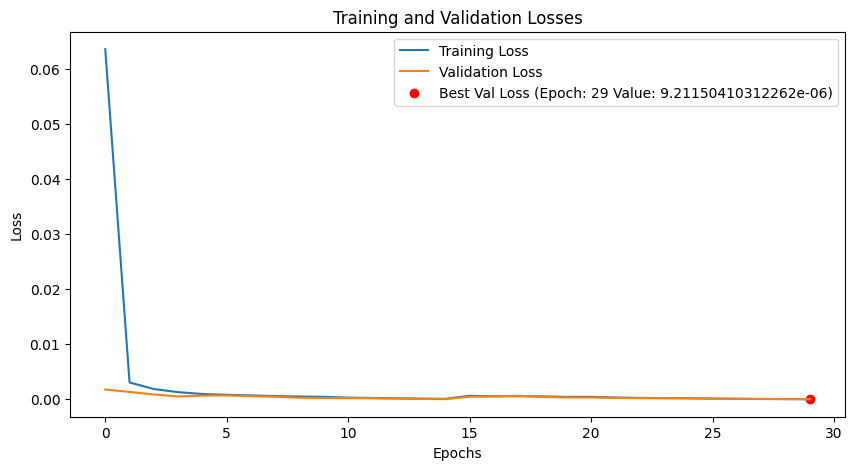

In [35]:
best_val_loss = min(val_losses)
best_val_loss_epoch = val_losses.index(best_val_loss)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.scatter(best_val_loss_epoch, best_val_loss, color='red', label=f'Best Val Loss (Epoch: {best_val_loss_epoch} Value: {best_val_loss})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

Embedding Graphs

In [ ]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    for i in range(8):
        inds = np.where(targets == i)[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5, color=colors[i], label=classes[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(loc='best')
    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.title("t-SNE Embeddings")

def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for data in dataloader:
            inputs, label = data
            inputs = inputs.to(device)

            embedding = model(inputs)

            embeddings.append(embedding.cpu().numpy())
            labels.append(label.cpu().numpy())

    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

test_embeddings_ocl, test_labels_ocl = extract_embeddings(audio_test_loader, embedding_model)


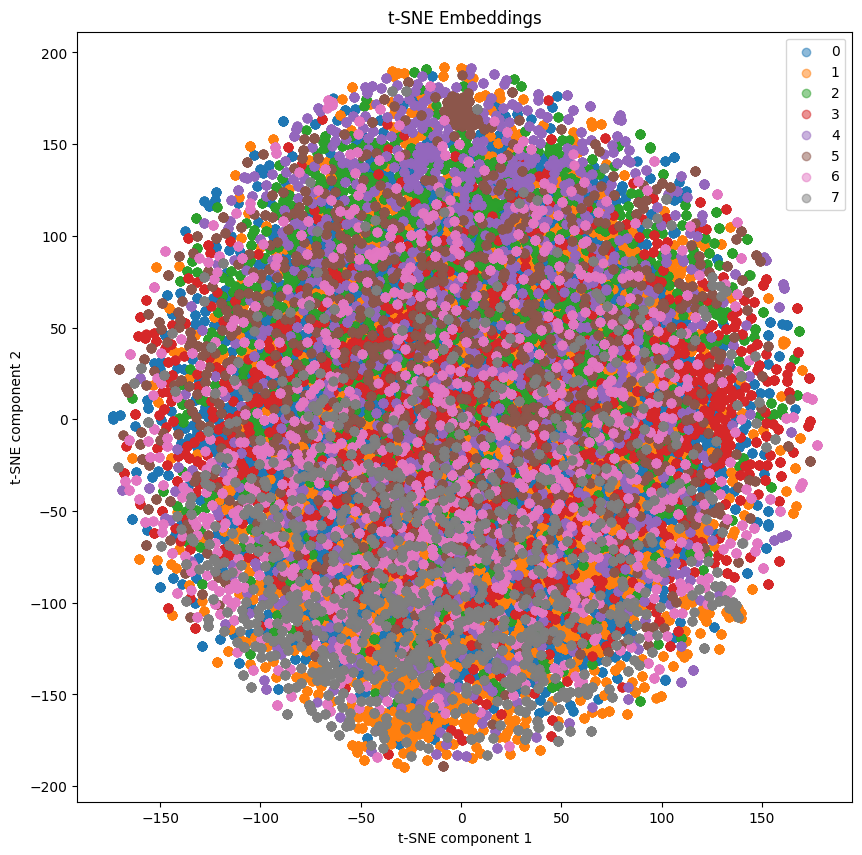

In [47]:
def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, perplexity=50, learning_rate=50, n_iter=5000, random_state=42)
    return tsne.fit_transform(embeddings)

test_embeddings_ocl_tsne = apply_tsne(test_embeddings_ocl)

plot_embeddings(test_embeddings_ocl_tsne, test_labels_ocl)
plt.show()

# Unassign

In [48]:
runtime.unassign()